In [460]:
import os.path as osp
import numpy as np
import torch
import json
from collections import defaultdict
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline


from modules.smpl_model._smpl import SMPL
from modules.smpl_model.config_smpl import *
from modules.utils.image_utils import to_tensor, transform, transform_visualize, crop_box

In [461]:
import numpy as np
import torch
import os.path as osp
import json

from smplpytorch.smplpytorch.pytorch.smpl_layer import SMPL_Layer


class SMPL(object):
    def __init__(self):
        self.layer = {'male': self.get_layer('male'), 'female': self.get_layer('female'),
                      'neutral': self.get_layer('neutral')}
        self.vertex_num = 6890
        self.face = self.layer['neutral'].th_faces.numpy()
        self.joint_regressor = self.layer['neutral'].th_J_regressor.numpy().astype(np.float32)  # smpl joint regressor
        self.joint_regressor_h36m = np.load(osp.join('./data', 'J_regressor_h36m_correct.npy')).astype(np.float32)
        #  'J_regressor_coco_use_extra_joint.npy' 'J_regressor_coco_all_smpl_joint.npy'
        # add nose, L/R eye, L/R ear
        self.face_kps_vertex = (331, 2802, 6262, 3489, 3990)  # mesh vertex idx
        nose_onehot = np.array([1 if i == 331 else 0 for i in range(self.joint_regressor.shape[1])],
                               dtype=np.float32).reshape(1, -1)
        left_eye_onehot = np.array([1 if i == 2802 else 0 for i in range(self.joint_regressor.shape[1])],
                                   dtype=np.float32).reshape(1, -1)
        right_eye_onehot = np.array([1 if i == 6262 else 0 for i in range(self.joint_regressor.shape[1])],
                                    dtype=np.float32).reshape(1, -1)
        left_ear_onehot = np.array([1 if i == 3489 else 0 for i in range(self.joint_regressor.shape[1])],
                                   dtype=np.float32).reshape(1, -1)
        right_ear_onehot = np.array([1 if i == 3990 else 0 for i in range(self.joint_regressor.shape[1])],
                                    dtype=np.float32).reshape(1, -1)
        self.joint_regressor = np.concatenate(
            (self.joint_regressor, nose_onehot, left_eye_onehot, right_eye_onehot, left_ear_onehot, right_ear_onehot))

        self.joint_num = 29  # original: 24. manually add nose, L/R eye, L/R ear
        self.joints_name = (
        'Pelvis', 'L_Hip', 'R_Hip', 'Torso', 'L_Knee', 'R_Knee', 'Spine', 'L_Ankle', 'R_Ankle', 'Chest', 'L_Toe',
        'R_Toe', 'Neck', 'L_Thorax', 'R_Thorax', 'Head', 'L_Shoulder', 'R_Shoulder', 'L_Elbow', 'R_Elbow', 'L_Wrist',
        'R_Wrist', 'L_Hand', 'R_Hand', 'Nose', 'L_Eye', 'R_Eye', 'L_Ear', 'R_Ear')
        self.part_segments_color = ('silver', 'blue', 'green', 'salmon', 'turquoise', 'olive', 'lavender', 'darkblue', 'lime', 'khaki', 'cyan', 'darkgreen',
                                    'beige', 'coral', 'crimson', 'red', 'aqua', 'chartreuse', 'indigo', 'teal', 'violet', 'orchid', 'orange', 'gold')
        self.flip_pairs = (
        (1, 2), (4, 5), (7, 8), (10, 11), (13, 14), (16, 17), (18, 19), (20, 21), (22, 23), (25, 26), (27, 28))
        self.skeleton = (
        (0, 1), (1, 4), (4, 7), (7, 10), (0, 2), (2, 5), (5, 8), (8, 11), (0, 3), (3, 6), (6, 9), (9, 14), (14, 17),
        (17, 19), (21, 23), (9, 13), (13, 16), (16, 18), (18, 20), (20, 22), (9, 12), (12, 24), (24, 14), (24, 25),
        (24, 26), (25, 27), (26, 28))
        self.root_joint_idx = self.joints_name.index('Pelvis')

    def get_layer(self, gender):
        gender='neutral'
        return SMPL_Layer(gender=gender, model_root='../smpl_models/')

In [462]:
class Human36M(torch.utils.data.Dataset):
    def __init__(self,
                data_path:str='../H36M',
                split:str = 'train',
                num_required_keypoints:int= 0,
                debug:bool=True,
                store_images=True,
                load_from_zarr:str=None,
                load_datalist:str=None,
                img_size=224):
        
        self.split = split
        self.img_dir = osp.join(data_path, 'Human36M', 'images')
        self.annot_dir = osp.join(data_path, 'Human36M', 'annotations')
        self.fitting_thr = 25  # milimeter --> Threshhold joints from smpl mesh to h36m gt
        if debug:
            self.subject_list = [1, 5]
        else:   
            self.subject_list = [1, 5, 6, 7, 8, 9, 11]
        self.datalist = get_data_list_h36m(annot_dir=self.annot_dir,
                                            subject_list=self.subject_list,
                                            fitting_thr=self.fitting_thr,
                                            load_from_pkl=load_datalist,
                                            store_as_pkl=False,
                                            out_dir=None,
                                            )

        if self.load_from_zarr is not None:
            self.imgs = torch.from_numpy(zarr.load(self.load_from_zarr)) ### Load array into memory
        elif self.store_images:
            self.img_size = img_size
            self.img_cache_indicator = torch.zeros(self.__len__(), dtype=torch.bool)
            self.img_cache = torch.empty(self.__len__(), 3, img_size, img_size, dtype=torch.float32)
  
    def __len__(self):
        return len(self.datalist)

    def __getitem__(self, index):
        data = copy.deepcopy(self.datalist[index])
        img_name = data['img_name']
        img_path = osp.joint(self.img_dir, data['img_name'])
        if self.load_from_zarr is not None:
            img_tensor = self.imgs[index]
        elif self.store_images and self.img_cache_indicator[index]:
            img_tensor = self.img_cache[index]
        else:
            img_name = data['img_name']
            img_path = osp.joint(self.img_dir, data['img_name'])
            img = np.array(Image.open(img_path))
            if data['bbox'] is not None:
                x_min, y_min, x_max, y_max = data['bbox']
                img = img[y_min:y_max, x_min:x_max]
            img_tensor = to_tensor(img)
            img_tensor = transform(img_tensor, img_size=self.img_size)
            if self.store_images:
                self.img_cache[index] = img_tensor
                self.img_cache_indicator[index] = True
        data['img_path'] = img_path
        data['img'] = img_tensor
        return data

In [463]:
def get_cam_pose_intr(cam_dict):
    cam_pose = torch.cat((torch.FloatTensor(cam_dict['R']), torch.FloatTensor(cam_dict['t'])[:,None]), dim = 1)
    cam_pose = torch.cat((cam_pose, torch.FloatTensor([[0, 0, 0, 1]])), dim=0)
    cam_intr = torch.zeros(3,3)
    cam_intr[0,0], cam_intr[1,1] = cam_dict['f']
    cam_intr[0:2,2] = torch.tensor(cam_dict['c'])
    cam_intr[2,2] = 1.
    return {'cam_pose': cam_pose, 'cam_intr': cam_intr}
                                

In [464]:
def get_fitting_error(joint3d_h36m_gt, joint3d_smpl):
    joint3d_h36m_gt = joint3d_h36m_gt - joint3d_h36m_gt[H36M_J17_NAME.index('Pelvis'), None,:] # root-relative
    # translation alignment
    joint3d_smpl = joint3d_smpl - np.mean(joint3d_smpl,0)[None,:] + np.mean(joint3d_h36m_gt,0)[None,:]
    error = np.sqrt(np.sum((joint3d_h36m_gt - joint3d_smpl)**2, 1)).mean()
    return error



In [29]:
import numpy as np
import os
import os.path as osp
import pickle as pkl
import json
from PIL import Image
import torch
from modules.smpl_model.config_smpl import *


def get_data_list_h36m(annot_dir:str,
                    subject_list:list,
                    fitting_thr:int,
                    load_from_pkl:str=None,
                    store_as_pkl:bool=False,
                    out_dir:str=None,
                    ):
        if load_from_pkl is not None:
            with open(load_from_pkl , "rb") as fp:
                datalist = pkl.load(fp)
        else:
            images = []
            cameras = {}
            smpl_params = {}
            joints = {}
            bboxes = {}
            for subject in subject_list:
                ### Load image annotations
                with open(osp.join(annot_dir, 'Human36M_subject' + str(subject) + '_data.json'), 'r') as f:
                    annotations = json.load(f)
                images.extend(annotations['images'])
                ### Load cameras
                with open(osp.join(annot_dir, 'Human36M_subject' + str(subject) + '_camera.json'), 'r') as f:
                    cams = json.load(f)
                cameras[str(subject)] = {cam_id: get_cam_pose_intr(cam) for cam_id, cam in cams.items()}
                ### Load fitted smpl parameter
                with open(osp.join(annot_dir, 'Human36M_subject' + str(subject) + '_smpl_param.json'), 'r') as f:
                    smpl_params[str(subject)] = json.load(f)
                ### Load 3d Joint ground truth (17x3)
                with open(osp.join(annot_dir, 'Human36M_subject' + str(subject) + '_joint_3d.json'), 'r') as f:
                    joints[str(subject)] = json.load(f)   
                    
            with open(osp.join(annot_dir, 'h36m_bboxes.json'), 'r') as f:
                    bboxes = json.load(f)
                    
            id_to_imgs = {} # Maps img-id to img file
            id_to_imgs = {img['id']: img for img in images}

            datalist = []
            num_smpl_param = 0
            for img_id, img in id_to_imgs.items():
                img_name =  img['file_name']  
                img_id = img['id']
                
                subject = img['subject']
                action = img['action_idx']
                subaction = img['subaction_idx']
                frame = img['frame_idx']; 
                
                ### check smpl parameter exist
                try:
                    smpl_param = smpl_params[str(subject)][str(action)][str(subaction)][str(frame)]
                except KeyError:
                    continue 
                ### check threshhold of h36m gt and smpl-mesh h36m joints
                joint3d_smpl = np.array(smpl_param['fitted_3d_pose'], np.float32)
                joint3d_h36m_gt = np.array(joints[str(subject)][str(action)][str(subaction)][str(frame)],
                                    dtype=np.float32)
                if get_fitting_error(joint3d_h36m_gt, joint3d_smpl) > fitting_thr: 
                    continue
                    
                beta = torch.FloatTensor(smpl_param['shape'])
                pose = torch.FloatTensor(smpl_param['pose'])
                trans = torch.FloatTensor(smpl_param['trans'])   
                cam_id = img['cam_idx']
                cam_param = cameras[str(subject)][str(cam_id)]
                cam_pose, cam_intr = torch.FloatTensor(cam_param['cam_pose']), torch.FloatTensor(cam_param['cam_intr'])
                bbox = bboxes[img_id]
                datalist.append({
                    'img_name': img_name,
                    'img_id': img_id,
                    'zarr_id': num_smpl_param,
                    'betas': beta,
                    'poses': pose,
                    'trans': trans,
                    'bbox': bbox,
                    'cam_pose': cam_pose,
                    'cam_intr': cam_intr,
                    })
                num_smpl_param +=1
            datalist = sorted(datalist, key=lambda x: x['img_id'])
        if store_as_pkl and out_dir is not None:
            sub_str = f'{min(subject_list)}to{max(subject_list)}'
            with open(osp.join(out_dir, f'datalist_h36m_thr{fitting_thr}_{sub_str}subj.pickle'), 'wb') as fp:
                pkl.dump(datalist, fp)
        return datalist

In [30]:
datalist = get_data_list_h36m(annot_dir='../H36M/annotations', fitting_thr=25, subject_list=[1, 5, 6, 7, 8, 9, 11], out_dir='../H36M', store_as_pkl=True)

KeyError: 0

In [31]:
images = []
cameras = {}
smpl_params = {}
joints = {}
bboxes = {}
for subject in subject_list:
    ### Load image annotations
    with open(osp.join(annot_dir, 'Human36M_subject' + str(subject) + '_data.json'), 'r') as f:
        annotations = json.load(f)
    images.extend(annotations['images'])
    ### Load cameras
    with open(osp.join(annot_dir, 'Human36M_subject' + str(subject) + '_camera.json'), 'r') as f:
        cams = json.load(f)
    cameras[str(subject)] = {cam_id: get_cam_pose_intr(cam) for cam_id, cam in cams.items()}
    ### Load fitted smpl parameter
    with open(osp.join(annot_dir, 'Human36M_subject' + str(subject) + '_smpl_param.json'), 'r') as f:
        smpl_params[str(subject)] = json.load(f)
    ### Load 3d Joint ground truth (17x3)
    with open(osp.join(annot_dir, 'Human36M_subject' + str(subject) + '_joint_3d.json'), 'r') as f:
        joints[str(subject)] = json.load(f)   

with open(osp.join(annot_dir, 'h36m_bboxes.json'), 'r') as f:
        bboxes = json.load(f)

id_to_imgs = {} # Maps img-id to img file
id_to_imgs = {img['id']: img for img in images}

datalist = []
num_smpl_param = 0

In [42]:
for img_id, img in id_to_imgs.items():
    img_name =  img['file_name']  
    img_id = img['id']

    subject = img['subject']
    action = img['action_idx']
    subaction = img['subaction_idx']
    frame = img['frame_idx']; 

    ### check smpl parameter exist
    try:
        smpl_param = smpl_params[str(subject)][str(action)][str(subaction)][str(frame)]
    except KeyError:
        continue 
    ### check threshhold of h36m gt and smpl-mesh h36m joints
    joint3d_smpl = np.array(smpl_param['fitted_3d_pose'], np.float32)
    joint3d_h36m_gt = np.array(joints[str(subject)][str(action)][str(subaction)][str(frame)],
                        dtype=np.float32)
    if get_fitting_error(joint3d_h36m_gt, joint3d_smpl) > fitting_thr: 
        continue
    cam_id = img['cam_idx']
    cam_param = cameras[str(subject)][str(cam_id)]
    cam_pose, cam_intr = torch.FloatTensor(cam_param['cam_pose']), torch.FloatTensor(cam_param['cam_intr'])
    
    beta, pose, trans = get_smpl_coord(smpl_param, cam_pose)
    trans = torch.FloatTensor(trans) 
    beta = torch.FloatTensor(beta)
    pose = torch.FloatTensor(pose)
    
    bbox = bboxes[str(img_id)]
    datalist.append({
        'img_name': img_name,
        'img_id': img_id,
        'zarr_id': num_smpl_param,
        'betas': beta,
        'poses': pose,
        'trans': trans,
        'bbox': bbox,
        'cam_pose': cam_pose,
        'cam_intr': cam_intr,
        })
    num_smpl_param +=1
    if img_id % 100000 == 0:
        print(img_id)
datalist = sorted(datalist, key=lambda x: x['img_id'])

0
1000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
45000
46000
47000
63000
64000
65000
66000
67000
68000
69000
84000
85000
96000
101000
109000
120000
121000
131000
132000
133000
137000
138000
154000
155000
156000
165000
166000
175000
176000
181000
183000
193000
194000
213000
214000
215000
228000
229000
237000
238000
248000
264000
265000
266000
267000
268000
271000
272000
338000
339000
340000
353000
354000
355000
356000
373000
374000
375000
414000
415000
416000
435000
436000
437000
450000
451000
452000
474000
475000
476000
477000
478000
487000
488000
489000
504000
505000
506000
521000
522000
523000
524000
525000
526000
527000
528000
529000
530000
531000
532000
533000
534000
535000
536000
550000
551000
552000
553000
583000
584000
585000
586000
587000
588000
589000
590000
591000
592000
593000
594000
595000
596000
611000
612000
630000
631000
632000
636000
637000
638000
648000
649000
650000
668000
669000
670000
6710

In [522]:
smpl = SMPL()

In [466]:
cam_pose = datalist[0]['cam_pose']
cam_intr = datalist[0]['cam_intr']
beta = datalist[0]['betas']
pose= datalist[0]['poses']
trans = datalist[0]['trans']

In [473]:
beta.shape

torch.Size([10])

In [469]:
smpl.layer['neutral'].th_shapedirs= smpl.layer['neutral'].th_shapedirs[:,:,:10]

In [471]:
verts, joints= smpl.layer['neutral'](th_betas=beta[None,:10],th_pose_axisang=pose[None], th_trans=trans)

In [492]:
from modules.smpl_model._smpl import SMPL as SMPL_old

In [527]:
smpl2 = SMPL_old()

In [423]:
verts2 = smpl2(poses[None], beta[None,:10])
joints2 = smpl2.get_joints(verts2)

In [181]:
import transforms3d

In [445]:
verts_cam1, joints_cam1 = get_smpl_coord(pose=pose[None], beta=beta[None], trans=trans, root_idx=0, cam_pose=cam_pose, smpl_model1=smpl.layer['neutral'])

tensor([[ 0.5010,  0.5672, -2.8093]])
tensor([[ 1.2278, -0.3323,  0.6706]])
[[-0.2932941  -0.24221188  0.6543717 ]
 [-0.2914552  -0.25233173  0.6416386 ]
 [-0.28025192 -0.24347933  0.6412458 ]
 ...
 [-0.35965264 -0.18705186  0.5303888 ]
 [-0.36090416 -0.18790497  0.53203243]
 [-0.36228803 -0.19120927  0.5296897 ]]
[[-0.00101866 -0.20932727  0.01142699]]


In [481]:
verts_cam1, _= get_smpl_coord(smpl_pose = pose,smpl_shape=beta,trans=trans, smpl_root_joint_idx=0,cam_pose=cam_pose,smpl=smpl.layer['neutral'])

In [484]:
verts_cam1 = torch.FloatTensor(verts_cam1)[None]

In [357]:
verts_cam1[10:20,0]

array([-15.895304, -11.013195, -14.552816, -10.125581, -12.388847,
       -15.972782,  23.005733,  16.597122,  13.487283,  20.328459],
      dtype=float32)

In [348]:
pose = torch.FloatTensor(smpl_param['pose'])[None,]
beta= torch.zeros(1,300)
beta[:, :10] = torch.FloatTensor(smpl_param['shape'])
trans = torch.FloatTensor(smpl_param['trans'])[None,]

In [349]:
verts_cam2, joints_cam2 = get_smpl_coord(pose=pose, beta=beta[:,:10], trans=trans, root_idx=0, cam_pose=cam_pose, smpl_model2=smpl2)

tensor([[1.4921, 0.3630, 0.3590]])
tensor([[-1.3110, -0.3511,  2.7792]])
[[-0.02288356 -0.90651375 -0.05927382]
 [-0.01881711 -0.89823776 -0.04494194]
 [-0.03004056 -0.89097726 -0.05137506]
 ...
 [ 0.07686706 -0.80480635 -0.10503801]
 [ 0.0774399  -0.8069192  -0.10458224]
 [ 0.07989586 -0.8061796  -0.1012185 ]]
[[ 0.00257893 -0.22054371  0.01620121]]


In [482]:
pose.shape, beta.shape, trans.shape, verts_cam1.shape, torch.zeros(3,1000,1000).shape, cam_pose.shape, cam_intr.shape

(torch.Size([72]),
 torch.Size([10]),
 torch.Size([1, 3]),
 (6890, 3),
 torch.Size([3, 1000, 1000]),
 torch.Size([4, 4]),
 torch.Size([3, 3]))

torch.Size([4, 4]) (3, 3)
(13776, 3) (6890, 3)
[ 0.433399   2.181117  -1.7972679] tensor([-346.0508,  546.9808, 5474.4810]) [1145.0494 1143.7811] [512.5415 515.4515]
1000 1000
6890


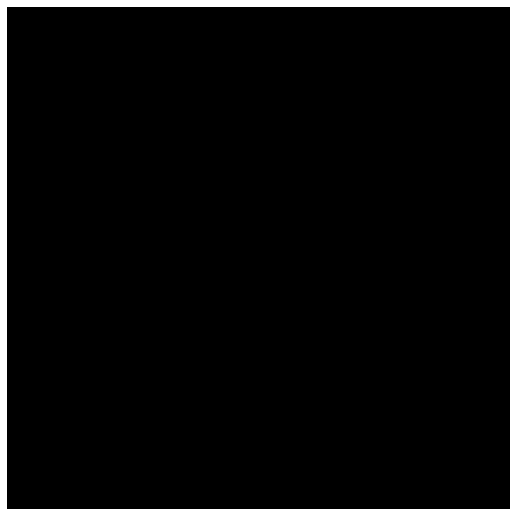

In [532]:
rend_img= visualize_mesh(torch.zeros(3,1000,1000), smpl=smpl2, cam_pose=cam_pose, cam_intr=cam_intr, vertices=verts_cam1, beta =None, pose=None)
plot_tensor(rend_img)

In [393]:
import torch.nn.functional as F
import numpy as np
from torchvision import transforms
import torch
from matplotlib import pyplot as plt
from modules.utils.image_utils import plot_tensor


from modules.utils.render import Renderer
from modules.utils.geometry import rotation_matrix_to_angle_axis
from modules.smpl_model._smpl import SMPL

from modules.smpl_model.smpl import SMPL, SMPL_MODEL_DIR, get_smpl_faces

In [531]:
def visualize_mesh(img, cam_pose, cam_intr, smpl, beta, pose, trans=None, vertices=None):
    cam_intr = cam_intr.detach().numpy()
    print(cam_pose.shape, cam_intr.shape)
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy().transpose(1,2,0)
    
    ## get smpl faces and vertices ##
    faces = smpl.faces.cpu().numpy()
    if vertices is None:   
        vertices = smpl(pose=pose, beta=beta) + trans
    
    vertices = vertices[0].detach().numpy()
    print(faces.shape,vertices.shape)
    ## camera: rotation matrix, t, f and center
    cam_rot = rotation_matrix_to_angle_axis(cam_pose[None, :3, :3]).detach().numpy().ravel() 
    cam_t = cam_pose[0:3,3]
    cam_f = np.array([cam_intr[0,0],cam_intr[1,1]])
    cam_center = cam_intr[0:2,2]
    print(cam_rot, cam_t, cam_f, cam_center)
    ## Visualize Mesh 
    renderer = Renderer(faces=faces)
    color= 'pink'
    focal_length = 1000
    rend_img = renderer.render(vertices,
                               cam_t= cam_t,
                               cam_rot= cam_rot,
                               cam_center= cam_center,
                               cam_f = cam_f,
                               img= img, 
                               use_bg = True,
                               focal_length = focal_length,
                               body_color = color)

    #return torch.Tensor
    rend_img = rend_img.transpose(2,0,1)
    rend_img = torch.from_numpy(rend_img.copy())
    return rend_img




In [518]:
def visualize_mesh(img, cam_pose, cam_intr, smpl, beta, pose, trans=None, vertices=None):
    cam_intr = cam_intr.detach().numpy()

    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy().transpose(1,2,0)
   

 ## get smpl faces and vertices ##

    #SMPLX Model: 
    if vertices is None:   
        vertices = smpl(pose = pose, beta = beta[:10]) + trans

    vertices = vertices[0].detach().numpy()
    faces = smpl.faces.cpu().numpy()
    
    # camera: rotation matrix, t, f and center
    cam_rot = rotation_matrix_to_angle_axis(cam_pose[None, :3, :3]).detach().numpy().ravel() 
    cam_t = cam_pose[0:3,3]
    cam_f = np.array([cam_intr[0,0],cam_intr[1,1]])
    cam_center = cam_intr[0:2,2]

    # Visualize Mesh 
    renderer = Renderer(faces=faces)
    color= 'pink'
    focal_length = 1000
    rend_img = renderer.render(vertices,
                               cam_t= cam_t,
                               cam_rot= cam_rot,
                               cam_center= cam_center,
                               cam_f = cam_f,
                               img= img, 
                               use_bg = True,
                               focal_length = focal_length,
                               body_color = color)

    #return torch.Tensor
    rend_img = rend_img.transpose(2,0,1)
    rend_img = torch.from_numpy(rend_img.copy())
    return rend_img

In [344]:
def get_smpl_coord(pose, beta, trans, root_idx, cam_pose, smpl_model1=None, smpl_model2=None):
        # smpl parameters (pose: 72 dimension, shape: 10 dimension)
        print(pose[:,:3])
        pose = pose.view(-1, 3)
        beta = beta.view(1, -1)
        # translation vector from smpl coordinate to h36m world coordinate
        trans = np.array(trans, dtype=np.float32).reshape(3)
        # camera rotation and translation
        R = np.array(cam_pose[:3, :3], dtype=np.float32).reshape(3, 3)
        t = np.array(cam_pose[0:3,3], dtype=np.float32).reshape(3)

        # change to mean shape if beta is too far from it
        beta[(beta.abs() > 3).any(dim=1)] = 0.

        # transform world coordinate to camera coordinate
        root_pose = pose[root_idx, :].numpy()
        angle = np.linalg.norm(root_pose)
        root_pose = transforms3d.axangles.axangle2mat(root_pose / angle, angle)
        root_pose = np.dot(R, root_pose)
        axis, angle = transforms3d.axangles.mat2axangle(root_pose)
        root_pose = axis * angle
        pose[root_idx] = torch.from_numpy(root_pose)
        pose = pose.view(1, -1)
        print(pose[:,:3])
        # get mesh and joint coordinates
        if smpl_model1 is not None:
            smpl_mesh_coord, smpl_joint_coord = smpl_model1(pose, beta)
        else: 
            smpl_mesh_coord = smpl_model2(pose, beta)
            smpl_joint_coord = smpl_model2.get_h36m_joints(smpl_mesh_coord)

        # incorporate face keypoints
        smpl_mesh_coord = smpl_mesh_coord.numpy().astype(np.float32).reshape(-1, 3);
        smpl_joint_coord = smpl_joint_coord.numpy().astype(np.float32).reshape(-1, 3)
        # smpl_face_kps_coord = smpl_mesh_coord[self.face_kps_vertex, :].reshape(-1, 3)
        # smpl_joint_coord = np.concatenate((smpl_joint_coord, smpl_face_kps_coord))
        print(smpl_mesh_coord[:,:3])
        # compenstate rotation (translation from origin to root joint was not cancled)
        smpl_trans = np.array(trans, dtype=np.float32).reshape(3)  # translation vector from smpl coordinate to h36m world coordinate
        smpl_trans = np.dot(R, smpl_trans[:, None]).reshape(1, 3) + t.reshape(1, 3) / 1000
        root_joint_coord = smpl_joint_coord[root_idx].reshape(1, 3)
        print(root_joint_coord)
        smpl_trans = smpl_trans - root_joint_coord + np.dot(R, root_joint_coord.transpose(1, 0)).transpose(1, 0)
        # translation
        smpl_mesh_coord += smpl_trans; smpl_joint_coord += smpl_trans

        # meter -> milimeter
        smpl_mesh_coord *= 1000; smpl_joint_coord *= 1000;

        return smpl_mesh_coord, smpl_joint_coord

In [524]:
len(datalist)

383332

In [479]:
def get_smpl_coord(smpl_pose,smpl_shape,trans, smpl_root_joint_idx,cam_pose,smpl):
        # smpl parameters (pose: 72 dimension, shape: 10 dimension)
        smpl_pose =  smpl_pose.view(-1, 3)
        smpl_shape = smpl_shape.view(1, -1)
        # translation vector from smpl coordinate to h36m world coordinate
        trans = np.array(trans, dtype=np.float32).reshape(3)
        # camera rotation and translation
        R = np.array(cam_pose[:3, :3], dtype=np.float32).reshape(3, 3)
        t = np.array(cam_pose[0:3,3], dtype=np.float32).reshape(3)
        # change to mean shape if beta is too far from it
        smpl_shape[(smpl_shape.abs() > 3).any(dim=1)] = 0.

        # transform world coordinate to camera coordinate
        root_pose = smpl_pose[smpl_root_joint_idx, :].numpy()
        angle = np.linalg.norm(root_pose)
        root_pose = transforms3d.axangles.axangle2mat(root_pose / angle, angle)
        root_pose = np.dot(R, root_pose)
        axis, angle = transforms3d.axangles.mat2axangle(root_pose)
        root_pose = axis * angle
        smpl_pose[smpl_root_joint_idx] = torch.from_numpy(root_pose)

        smpl_pose = smpl_pose.view(1, -1)

        # get mesh and joint coordinates
        smpl_mesh_coord, smpl_joint_coord = smpl(smpl_pose, smpl_shape)

        # incorporate face keypoints
        smpl_mesh_coord = smpl_mesh_coord.numpy().astype(np.float32).reshape(-1, 3);
        smpl_joint_coord = smpl_joint_coord.numpy().astype(np.float32).reshape(-1, 3)
        # smpl_face_kps_coord = smpl_mesh_coord[self.face_kps_vertex, :].reshape(-1, 3)
        # smpl_joint_coord = np.concatenate((smpl_joint_coord, smpl_face_kps_coord))

        # compenstate rotation (translation from origin to root joint was not cancled)
        smpl_trans = np.array(trans, dtype=np.float32).reshape(
            3)  # translation vector from smpl coordinate to h36m world coordinate
        smpl_trans = np.dot(R, smpl_trans[:, None]).reshape(1, 3) + t.reshape(1, 3) / 1000
        root_joint_coord = smpl_joint_coord[smpl_root_joint_idx].reshape(1, 3)
        smpl_trans = smpl_trans - root_joint_coord + np.dot(R, root_joint_coord.transpose(1, 0)).transpose(1, 0)

        # translation
        smpl_mesh_coord += smpl_trans; smpl_joint_coord += smpl_trans

        # meter -> milimeter
        smpl_mesh_coord *= 1000; smpl_joint_coord *= 1000;

        return smpl_mesh_coord, smpl_joint_coord

In [80]:
def get_shape_array(subject, smpl_params):
    shape_subject = []
    for act in sorted(smpl_params[subject].keys()):
        for subact in sorted(smpl_params[subject][act].keys()):
            for frame in sorted(smpl_params[subject][act][subact].keys()):
                shape_subject.append(np.array(smpl_params[subject][act][subact][frame]['shape']))        
    return np.array(shape_subject)

In [108]:
np.min([np.array([1,2]), np.array([2,-2])], axis=0)

array([ 1, -2])

In [113]:
def plot_shapes(smpl_params, x, y):
    plt.figure(figsize = (16,9))
    plt.title('shapes of all subjects')
    x_min = y_min = np.Inf
    x_max = y_max = - np.Inf
    for subject in smpl_params.keys():
        shape_subject = get_shape_array(subject, smpl_params).T[[x,y]].T
        shape_mean = shape_subject.mean(axis=0)
        shape_std = shape_subject.std(axis=0)
        x_min, y_min = np.min([np.array([x_min, y_min]), shape_mean - 2*shape_std], axis=0)
        x_max, y_max = np.max([np.array([x_max, y_max]), shape_mean + 2*shape_std], axis=0)
        plt.plot(shape_subject[:,0], shape_subject[:,1], ',', label=f'subject:{subject}') 
    plt.xlim([int(x_min), int(x_max+1)])
    plt.ylim([int(y_min), int(y_max+1)])
    plt.legend()
    plt.show()

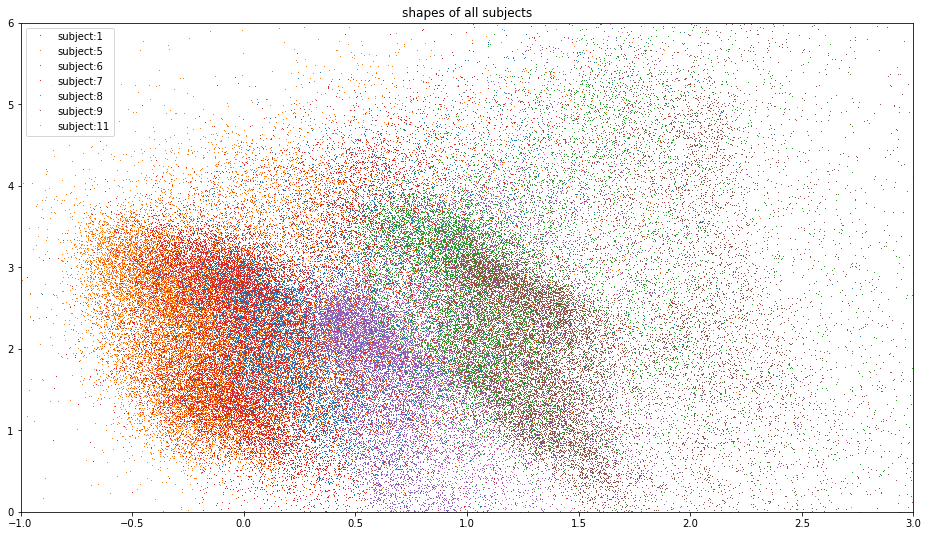

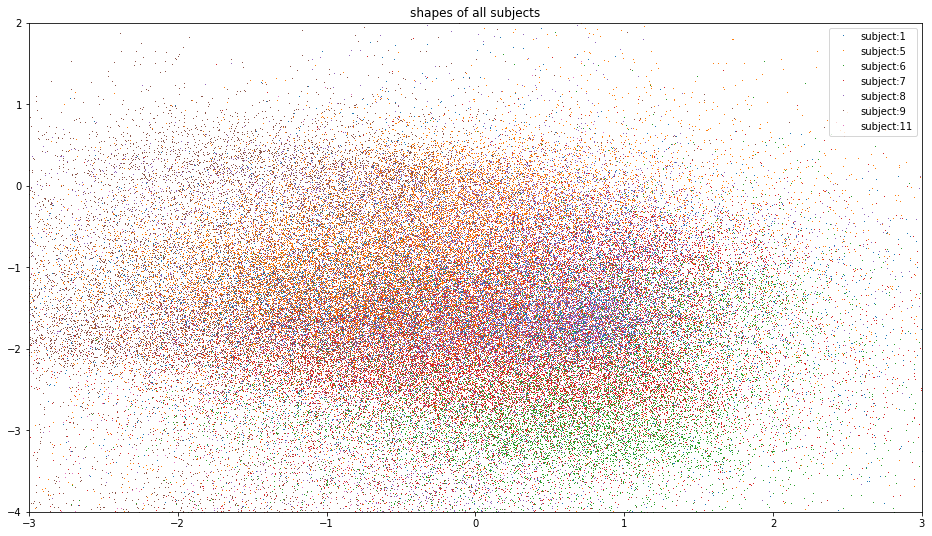

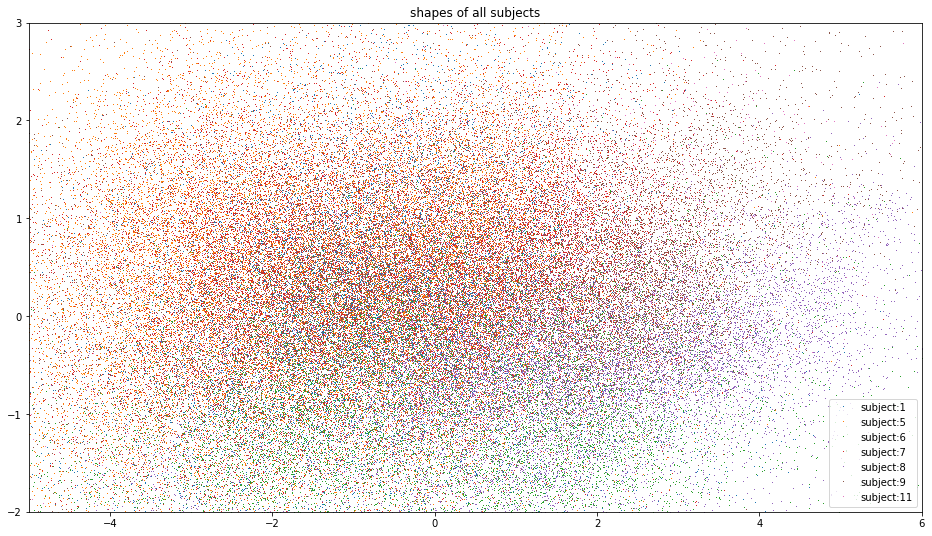

In [114]:
plot_shapes(smpl_params, 0, 1)
plot_shapes(smpl_params, 2, 3)
plot_shapes(smpl_params, 4, 5)

In [57]:
shape_s1 = np.array([smpl_params['1']['3']['1'][key]['shape'] for key in sorted(smpl_params['1']['3']['1'].keys())])

In [64]:
mean_shape_s1 = shape_s1.mean(axis=0)
sd_shape_s1 = shape_s1.std(axis=0)

In [61]:
shape_s5 = np.array([smpl_params['5']['3']['1'][key]['shape'] for key in sorted(smpl_params['5']['3']['1'].keys())])

In [66]:
mean_shape_s5= shape_s5.mean(axis=0)
sd_shape_s5 = shape_s5.std(axis=0)

In [63]:
mean_shape_s1, mean_shape_s5

(array([ 0.15224262,  1.99023816, -0.14677977, -1.36446614, -0.65323128,
         0.16910433, -0.68874236,  1.25956659,  1.10403595,  0.06503757]),
 array([-0.16887806,  2.36399764, -0.40883962, -1.05256575, -1.37333563,
         0.31692802, -0.36262898,  0.40090416,  0.50984386, -0.37906871]))

In [67]:
sd_shape_s1, sd_shape_s5

(array([0.17450503, 0.54400116, 1.04524472, 0.53252036, 1.23046891,
        0.84416134, 0.81673065, 0.96658398, 0.68593381, 0.55068899]),
 array([0.38451538, 0.93552818, 0.99549527, 0.86066095, 1.71387139,
        1.00810045, 1.03315124, 0.82715984, 0.89979926, 0.80772827]))

In [68]:
abs(mean_shape_s1 - mean_shape_s5)

array([0.32112068, 0.37375947, 0.26205986, 0.31190038, 0.72010435,
       0.1478237 , 0.32611339, 0.85866243, 0.5941921 , 0.44410628])

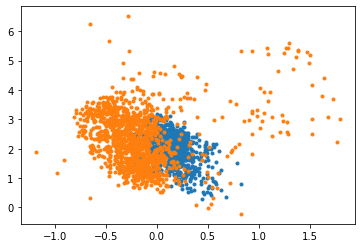

In [74]:
plt.plot(shape_s1[:,0], shape_s1[:,1], '.')
plt.plot(shape_s5[:,0], shape_s5[:,1], '.')

In [48]:
datalist[:20]

[{'img_name': 's_01_act_02_subact_01_ca_01/s_01_act_02_subact_01_ca_01_000001.jpg',
  'img_id': 0,
  'zarr_id': 0,
  'betas': tensor([-1.8462e-03,  2.7643e+00,  1.2039e+00, -8.2339e-01,  1.2907e+00,
           2.2740e-01, -1.1659e+00,  1.5221e+00,  1.2080e+00,  7.3959e-01]),
  'poses': tensor([ 1.3168, -0.2108,  0.0803,  0.2989, -0.0784, -0.3409, -0.0876,  0.0475,
          -0.2178,  0.0953,  0.0511, -0.1107, -0.1214, -0.0750,  0.0342,  0.5660,
           0.0623, -0.1724,  0.3057, -0.0240, -0.0771, -0.2109,  0.4316,  0.2548,
           0.0246, -0.3382,  0.1052, -0.1901,  0.0337, -0.0629,  0.0451,  0.0487,
           0.0465,  0.0543, -0.0168,  0.0084,  0.1574, -0.1629,  0.0101,  0.0385,
          -0.2535, -0.5376,  0.0452,  0.2891,  0.4968, -0.2393, -0.0104,  0.1560,
           0.1097, -0.2131, -0.7151,  0.1002,  0.1217,  0.9538, -0.0737, -0.4567,
           0.2189, -0.2169,  0.2923, -0.2417,  0.3655, -0.1716, -0.2278,  0.2898,
          -0.0167,  0.1293,  0.0000,  0.0000,  0.0000,  0.0

In [44]:
if store_as_pkl and out_dir is not None:
    sub_str = f'{min(subject_list)}to{max(subject_list)}'
    with open(osp.join(out_dir, f'datalist_h36m_thr{fitting_thr}_{sub_str}subj.pickle'), 'wb') as fp:
        pkl.dump(datalist, fp)